# <center> Module 2 Project  - Northwind Database Hypothesis Testing

## <center>Matthew Sparr <br><br> <center><h8>Self-Paced Data Science Program

# <center> Introduction

#### <center> In this project we will be working with the Northwind Database. This is a sample database provided by Microsoft which contains sales data for a ficticious specialty foods company. We will be posing several questions for which we will develop and test hypotheses in effort to present important information for the company.

First we will import all the necessary libraries.

In [1]:
import sqlite3 as sql
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import preprocessing
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
from scipy import stats
from sklearn import linear_model as lm
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

C:\Users\sparr\Anaconda3\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


Next we will connect to the database and grab all the table names.

In [2]:
conn = sql.connect('Northwind_small.sqlite')
cur = conn.cursor()
table_names = list(cur.execute('''SELECT name FROM sqlite_master WHERE TYPE = 'table'
                               ''').fetchall())
table_names

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

Now we will store each table from the database as Pandas Dataframe so that they are easy to work with and analyze. There was a technical error with the 'orders' table, so a CSV file of the table was generated using an outside program.

In [3]:
sql_comm = []
for i in range(0,len(table_names)):
    s = "SELECT * FROM " + table_names[i][0]
    sql_comm.append(s)

employees = pd.read_sql_query(sql_comm[0], conn)
categories = pd.read_sql_query(sql_comm[1], conn)
customers = pd.read_sql_query(sql_comm[2], conn)
shippers = pd.read_sql_query(sql_comm[3], conn)

suppliers = pd.read_sql_query(sql_comm[4], conn)
products = pd.read_sql_query(sql_comm[6], conn)
order_details = pd.read_sql_query(sql_comm[7], conn)
orders = pd.read_csv('Order.csv')

cust_cust_demos = pd.read_sql_query(sql_comm[8], conn)
cust_demos = pd.read_sql_query(sql_comm[9], conn)
regions = pd.read_sql_query(sql_comm[10], conn)
territories = pd.read_sql_query(sql_comm[11], conn)
emp_territories = pd.read_sql_query(sql_comm[12], conn)

And here is a schema of the database.

<img src='Northwind_ERD.png'>

## Q1 -- Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

## <center>H<sub>0: The average quantity of product ordered is the same for orders with and without a discount.

## <center>H<sub>a: The average quantity of product ordered when a discount is given is higher or lower than for orders without a discount.

The above is our first question and both the null and alternative hypotheses. To test them will involve a two-tail test. This is because if the null hypothesis is rejected and there is a correlation between discount and order quantity, we could find that the discount amount either increases or decreases the quantity of product ordered. 

To test our hypotheses we will be using the table 'order_details' and will be looking only at the columns 'Quantity' and 'Discount'. Below we can see that there are no null or missing values in either column. Also, 'Quantity' ranges from 1 to 130 and 'Discount' ranges from 0 to 0.25.

In [4]:
order_details[['Quantity','Discount']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 2 columns):
Quantity    2155 non-null int64
Discount    2155 non-null float64
dtypes: float64(1), int64(1)
memory usage: 33.8 KB


In [5]:
order_details[['Quantity','Discount']].describe()

,Quantity,Discount
count,2155.000000,2155.000000
mean,23.812993,0.056167
std,19.022047,0.083450
min,1.000000,0.000000
25%,10.000000,0.000000
50%,20.000000,0.000000
75%,30.000000,0.100000
max,130.000000,0.250000


In [40]:
order_details['Discount_bin'] = order_details['Discount'].apply(lambda x: 1 if x > 0 else 0)

Text(0.5,1,'Discount v.s. No Discount Average Quantity of Product Per Order')

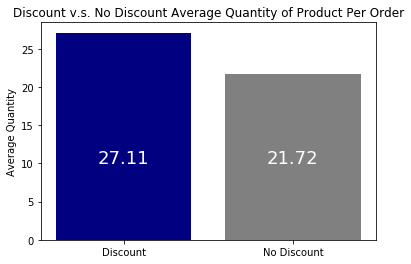

In [89]:
X = ['Discount', 'No Discount']
y = [order_details['Quantity'][order_details['Discount_bin'] == 1].mean(),
     order_details['Quantity'][order_details['Discount_bin'] == 0].mean()]
plt.bar(X,y, color=('navy','grey'))
plt.text(s=round(y[1],2), x=1, y=10, color="w", horizontalalignment='center',size=18)
plt.text(s=round(y[0],2), x=0, y=10, color="w", horizontalalignment='center',size=18)
plt.ylabel('Average Quantity')
plt.title('Discount v.s. No Discount Average Quantity of Product Per Order')

Now we will split our order details into two sets: discount and no discount. Running a t-test on the data below then gives us a small p-value of 1.14e-10 which is less than our alpha of 0.05.

In [6]:
no_disc = order_details[order_details['Discount'] == 0].copy()
disc = order_details[order_details['Discount'] > 0].copy()

p = stats.ttest_ind(no_disc.Quantity, disc.Quantity)[1]
p

1.1440924523215966e-10

Since the p-value for our t-test is so low, this allows us to reject the null-hypothesis and accept instead the alternative hypothesis. From this result we can reasonably argue that having a discount does indeed have an impact on the quantity of product ordered. 

For the second part of the question we will need to look at the different discount amounts and see where the size of the discount affects the quantity ordered the most. Let's start by creating a dataframe with only orders with a 'Discount' and then viewing the value counts.

In [7]:
q1_data = order_details[order_details['Discount'] > 0]

In [8]:
q1_data.Discount.value_counts()

0.05    185
0.10    173
0.20    161
0.15    157
0.25    154
0.03      3
0.02      2
0.04      1
0.06      1
0.01      1
Name: Discount, dtype: int64

Since the count of some 'Discount' values are so few compared to others, we will group those discount values together. By adjusting those values of 'Discount' (0.01, 0.02, 0.03, 0.04, and 0.06) to 0.05, we will have 5 buckets with similar value counts.

In [101]:
q1_data['Discount'] = q1_data['Discount'].apply(lambda x: 0.05 if (x > 0) & (x < 0.10) else x)
q1_data['Discount'].value_counts()

C:\Users\sparr\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0.05    193
0.10    173
0.20    161
0.15    157
0.25    154
Name: Discount, dtype: int64

For this second part of the question, we will need another null and alternative hypothesis.

## <center>H<sub>0: The average quantity of product ordered is the same for each discount level.

## <center>H<sub>a: The average quantity of product ordered differs across the discount levels.

Since we want to test for difference of mean, we can use an analysis of variance or one-way ANOVA test to resolve our hypotheses. Since we have 5 distinct 'Discount' values we will run this ANOVA with 'Discount' as a categorical variable.

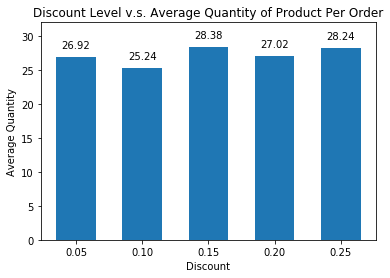

In [159]:
X = []
y = []
for i in q1_data['Discount'].unique():
    X.append(i)
    y.append(q1_data['Quantity'][q1_data['Discount'] == i].mean())
ax = plt.bar(X,y,width=.03)
plt.ylim(0,32)
plt.ylabel('Average Quantity')
plt.xlabel('Discount')
plt.title('Discount Level v.s. Average Quantity of Product Per Order')
rects = ax.patches
# Make some labels.
y_round = []
for i in y:
    y_round.append(round(i,2))
labels = y_round

for rect, label in zip(rects, labels):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height + 1, label,
            ha='center', va='bottom')

In [10]:
formula = 'Quantity ~ C(Discount)'
lm = ols(formula, q1_data).fit()
table = sm.stats.anova_lm(lm, typ=1)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(Discount),4.0,1065.701253,266.425313,0.616376,0.650947
Residual,833.0,360060.198508,432.245136,NaN,NaN


The p-value of our categorical 'Discount' variable is ~0.651 as shown in the above table. Since this value is much higher than our alpha of 0.05, we fail to reject the null hypothesis. This suggests that the average quantities of product ordered across the discount levels are not significantly different.

### Our findings show that having a discount on a product most likely will increase the quantity of product order but the actual amount of discount is statistically insignificant. 

## Q2 -- Are there certain products that are better to discount than others in order to increase the quantity ordered?

As a follow-up to our initial question, we will investigate whether or not the category of product intereacts with whether or not a discount is applied in regards to quantity of product ordered.

## <center>H<sub>0: There is no interaction between category of product and whether or not a discount is applied.

## <center>H<sub>a: There is some interaction between category of product and whether or not a discount is applied.

To test our hypothesis we will need data from more than one table so we will need to perform a couple merges. We will first join the 'products' table to the 'order-details' table as 'prod_ord_details'; and then merge that table with the 'categories' table.

In [11]:
prod_ord_details = pd.merge(products, 
                  order_details,
                  left_on='Id',
                  right_on='ProductId',
                  how='left')
prod_cat = pd.merge(prod_ord_details, 
                  categories,
                  left_on='CategoryId',
                  right_on='Id',
                  how='left')
prod_cat.head()

,Id_x,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice_x,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued,Id_y,OrderId,ProductId,UnitPrice_y,Quantity,Discount,Id,CategoryName,Description
0,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,10285/1,10285,1,14.4,45,0.20,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,10294/1,10294,1,14.4,18,0.00,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
2,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,10317/1,10317,1,14.4,20,0.00,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
3,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,10348/1,10348,1,14.4,15,0.15,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
4,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,10354/1,10354,1,14.4,12,0.00,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"


Viewing the head of the merged table we can see lots of variables we don't need. We will create a new DataFrame with only the categories we need: 'Quantity', 'Discount', and 'CategoryName'.

In [12]:
q2_data = prod_cat[['Quantity', 'Discount', 'CategoryName']]
q2_data.head()

,Quantity,Discount,CategoryName
0,45,0.20,Beverages
1,18,0.00,Beverages
2,20,0.00,Beverages
3,15,0.15,Beverages
4,12,0.00,Beverages


Since we are concerned with the interaction between category and whether or not a discount is applied, we will need to modify our 'Discount' column to make it binary. We will do this by making all values of discount greater than zero equal to 1 and leaving no discount instances as 0.

In [13]:
q2_data['Discount'] = q2_data['Discount'].apply(lambda x: 1 if x > 0 else 0)

C:\Users\sparr\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Since we want to test the impact of a variable ('Discount') on the dependent variable ('Quantity') for multiple groups ('CategoryName'), we will use analysis of variance or ANOVA to test our hypothesis. 

In [14]:
formula = 'Quantity ~ C(CategoryName)*C(Discount)'
lm = ols(formula, q2_data).fit()
table = sm.stats.anova_lm(lm, typ=2)
table

,sum_sq,df,F,PR(>F)
C(CategoryName),1118.470015,7.0,0.449689,8.708672e-01
C(Discount),14729.606130,1.0,41.454988,1.484744e-10
C(CategoryName):C(Discount),3357.463105,7.0,1.349892,2.226259e-01
Residual,760020.189876,2139.0,NaN,NaN


From the above table we can see that the interaction of 'CategoryName' and 'Discount' has a p-value of ~0.223. Since this is less than our alpha of 0.05, we fail to reject the null hypothesis. From these results, it appears there is no significant difference in quantity of product ordered across the different combinations of category and whether or not a discount is applied. 

We can also view an interaction plot of our variables to show this lack of interaction.

Text(0.5,0,'')

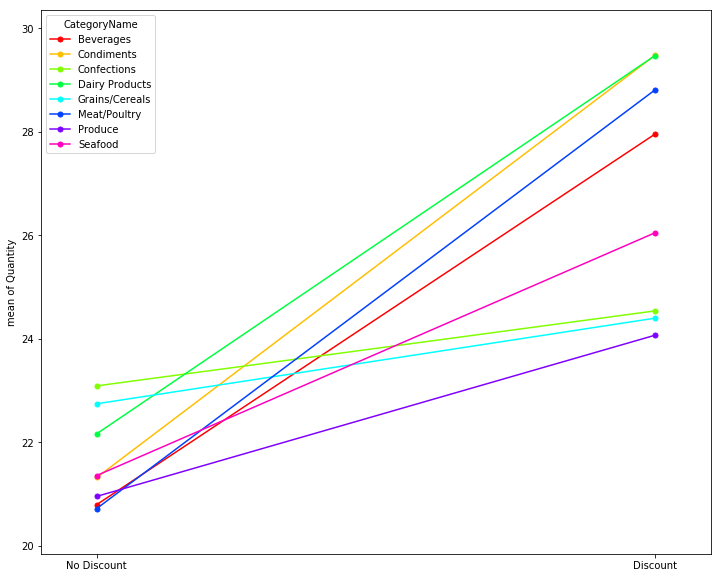

In [180]:
plt.figure(figsize=(12,10))
fig = interaction_plot(q2_data['Discount'],q2_data['CategoryName'],q2_data['Quantity'], ms=10, ax=plt.gca())
plt.xticks(np.arange(0,1.5,step=1), ('No Discount', 'Discount'))
plt.xlabel('')

We can see from the above graph that the lines for each of the category are mostly parallel with each other which implies little to no interaction with the other independent variable 'Discount'. The categories of 'Confections' and 'Grains/Cereals' do have slightly different slopes than the other categories but according to our ANOVA results, this difference is not significant.

### Our findings signify that there is not sufficient evidence that certain categories benefit more than others from having a discount applied versus not providing a discount. There may be some slight differences between certain categories but the differences overall are not statistically significant.

## Q3 -- Is there an optimal discount level based on the price of the product?

For this question we are wondering whether or not there is an interaction between 'Discount' and 'UnitPrice'. From this we can learn whether a certain discount level can lead to a higher 'Quantity' of product ordered depending on the product's price.

## <center>H<sub>0: There is no interaction between the discount level and unit price in regards to quantity.

## <center>H<sub>a: There is some interaction between discount level and unit price in regards to quantity.

To answer this question we will first need to create a relevant data table. Since we are only concerned with 'UnitPrice', 'Discount' and 'Quantity', we can simply grab those from the 'order_details' table.

In [16]:
q3_data = order_details[['UnitPrice', 'Discount', 'Quantity']].copy()

From the first question, we know that there are a couple 'Discount' values with few instances.

In [17]:
q3_data['Discount'].value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

Since the values with low value counts are all close to 0.05, we will modify those few 'Discount' levels and set them equal to 0.05.

In [18]:
q3_data['Discount'] = q3_data['Discount'].apply(lambda x: 0.05 if (x > 0) & (x < 0.10) else x)

In [19]:
q3_data['Discount'].value_counts()

0.00    1317
0.05     193
0.10     173
0.20     161
0.15     157
0.25     154
Name: Discount, dtype: int64

Since we are looking to analyze the interaction between a categorical variable 'Discount' and a continuous variable 'UnitPrice' we will use analysis of covariance or ANCOVA to answer our hypothesis.

In [20]:
formula = 'Quantity ~ C(Discount)*UnitPrice'
lm = ols(formula, q3_data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Quantity   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     4.592
Date:                Thu, 29 Nov 2018   Prob (F-statistic):           6.18e-07
Time:                        14:02:53   Log-Likelihood:                -9380.0
No. Observations:                2155   AIC:                         1.878e+04
Df Residuals:                    2143   BIC:                         1.885e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        21.6653      0.692     31.297      0.000      20.308      23.023
C(Discount)[T.0.05]               5.6568      1.839      3.076      0.002       2.051       9.263
C(Discount)[T.0.1]                4.8518      1.981      2.449      0.014       0.967       8.736
C(Discount)[T.0.15]               6.3929      2.720      2.350      0.019       1.058      11.728
C(Discount)[T.0.2]                3.2313      2.154      1.500      0.134      -0.992       7.455
C(Discount)[T.0.25]               4.5212      2.241      2.018      0.044       0.127       8.916
UnitPrice                         0.0019      0.017      0.109      0.913      -0.032       0.036
C(Discount)[T.0.05]:UnitPrice    -0.0149      0.038     -0.395      0.693      -0.089       0.059
C(Discount)[T.0.1]:UnitPrice     -0.0528      0.050     -1.055      0.291      -0.151       0.045
C(Discount)[T.0.15]:UnitPrice     0.0122      0.096      0.128      0.898      -0.175       0.200
C(Discount)[T.0.2]:UnitPrice      0.0886      0.062      1.430      0.153      -0.033       0.210
C(Discount)[T.0.25]:UnitPrice     0.0709      0.056      1.270      0.204      -0.039       0.180
==============================================================================
Omnibus:                      787.916   Durbin-Watson:                   1.636
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3092.282
Skew:                           1.769   Prob(JB):                         0.00
Kurtosis:                       7.682   Cond. No.                         281.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the above results we can see that the p-values for each of our interaction terms are all greater than our alpha value. We thus fail to reject our null hypothesis. This suggests that there is no significant interaction between 'Discount' level and 'UnitPrice'. 

The low R-squared value of 0.008 for the model also shows how poor of a fit a regression using only 'Discount' level and 'UnitPrice' are in predicting the 'Quantity' of product ordered.

### Our findings suggest there is no optimal discount level given the price of a product. 

## Q4 -- Do some employees perform better in terms of average order price than others?

## <center>H<sub>0: The average amount spent per order is the same across all employees.

## <center>H<sub>0: The average amount spent per order varies amongst employees.

To investigate this question we will need the variables of 'EmployeeId', 'Quantity', 'Discount', and 'UnitPrice'. To get these variables we will need to merge the 'orders' table with the 'order_details' table.

In [21]:
q4_data = pd.merge(orders, 
                  order_details,
                  left_on='Id',
                  right_on='OrderId',
                  how='left')
q4_data.head()

,Id_x,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,Id_y,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,10248/11,10248,11,14.0,12,0.0
1,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,10248/42,10248,42,9.8,10,0.0
2,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,10248/72,10248,72,34.8,5,0.0
3,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,10249/14,10249,14,18.6,9,0.0
4,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,10249/51,10249,51,42.4,40,0.0


Now we will need to create a new column named 'Sale' which will be the total dollar amount spent on each order. We will find this by using the 'UnitPrice', 'Quantity', and 'Discount' in the below formula.

In [22]:
q4_data['Sale'] = q4_data['Quantity']*(q4_data['UnitPrice']*(1 - q4_data['Discount']))

We can now initially view the average sale amount for each employee.

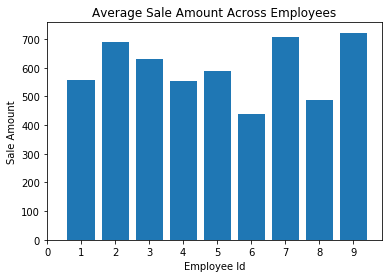

In [23]:
X = q4_data['EmployeeId']
y = []
for i in q4_data['EmployeeId']:
    y.append(q4_data['Sale'][q4_data['EmployeeId'] == i].mean())
plt.bar(X,y)
plt.xlabel('Employee Id')
plt.ylabel('Sale Amount')
plt.title('Average Sale Amount Across Employees')
plt.xticks(np.arange(0, 10, step=1))
plt.show()

From the above bar graph, we can see that the average sale amount does vary across the employees. To get a better idea of whether this variance is significant or not we can use an ANOVA.

In [24]:
formula = 'Sale ~ C(EmployeeId)'
lm = ols(formula, q4_data).fit()
table = sm.stats.anova_lm(lm, typ=1)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(EmployeeId),8.0,1.472611e+07,1.840763e+06,1.966553,0.046929
Residual,2146.0,2.008732e+09,9.360354e+05,NaN,NaN


From the above table we can see that we got a p-value of ~0.0469 which is below our alpha of 0.05. This suggests that there is a statistically significant difference in sale amount across the employees. To further investigate and find out where this difference exists, we can run a Tukey HSD to determine if any certain employee performs better than another employee. 

In [25]:
mc = MultiComparison(q4_data['Sale'], q4_data['EmployeeId'])
result = mc.tukeyhsd()
print(result)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2  meandiff   lower    upper   reject
-------------------------------------------------
  1      2     134.1944 -117.9953 386.3841 False 
  1      3     74.9821  -157.9727 307.9368 False 
  1      4     -2.3316  -220.6011 215.9379 False 
  1      5     31.1346  -290.2426 352.5118 False 
  1      6    -116.8745 -399.4868 165.7378 False 
  1      7     150.9404 -127.3188 429.1996 False 
  1      8     -68.9018 -315.6068 177.8032 False 
  1      9     165.6717 -166.7309 498.0742 False 
  2      3     -59.2123 -315.2499 196.8252 False 
  2      4     -136.526 -379.2787 106.2267 False 
  2      5    -103.0598 -441.5426 235.423  False 
  2      6    -251.0689 -552.9911 50.8533  False 
  2      7      16.746  -281.1054 314.5975 False 
  2      8    -203.0962  -471.705 65.5126  False 
  2      9     31.4773  -317.4909 380.4454 False 
  3      4     -77.3137 -300.0179 145.3906 False 
  3      5     -43.8475  -368.253 280.558  False 

Keeping our family-wise error rate at 0.05, we can see that out of all possible comparisons of employees, none of them are significant enough to allow us to reject the null hypothesis and say that one employee performs better than another.

### Our findings suggest there is some significant variance in average sale amount across employees but we cannot definitively say any one employee performs better than another in a statistically significant way.

## Q5 -- Are some employees better at others at selling a certain category of product?

As a follow up to Q4, we can investigate whether or not some employees have significantly better sale amounts for a particular category of product when compared to other employees. To answer this question we will use the metric of sale price and whether or not there is an interaction between 'EmployeeId' and 'CategoryName' of each order.

## <center>H<sub>0: There is no interaction between employee and category of product in regards to sale price of orders.

## <center>H<sub>a: There is some interaction between employee and category of product in regards to sale price of orders.

For this question we will need the variables 'EmployeeId', 'CategoryName', 'Quantity', 'UnitPrice', and 'Discount'. To get these variables into one table we will merge the tables 'orders', 'order_details', 'products', and 'categories'. We will then need to create a column 'Sale' as in the previous question.

In [26]:
q5_data = pd.merge(orders, 
                  order_details,
                  left_on='Id',
                  right_on='OrderId',
                  how='left')
q5_data = pd.merge(q5_data, 
                  products,
                  left_on='ProductId',
                  right_on='Id',
                  how='left')
q5_data = pd.merge(q5_data, 
                  categories,
                  left_on='CategoryId',
                  right_on='Id',
                  how='left')
q5_data = q5_data.rename(index=str, columns={"UnitPrice_x": "UnitPrice"})
q5_data['Sale'] = q5_data['Quantity']*(q5_data['UnitPrice']*(1 - q5_data['Discount']))
q5_data = q5_data[['EmployeeId', 'CategoryName', 'Sale']]
q5_data.head()

,EmployeeId,CategoryName,Sale
0,5,Dairy Products,168.0
1,5,Grains/Cereals,98.0
2,5,Dairy Products,174.0
3,6,Produce,167.4
4,6,Produce,1696.0


Since we are concerned with the interaction of two categorical variables, 'EmployeeId' and 'CategoryName', we can use a two-way ANOVA to see if that interaction is significant.

In [27]:
formula = 'Sale ~ C(EmployeeId)*C(CategoryName)'
lm = ols(formula, q5_data).fit()
table = sm.stats.anova_lm(lm, typ=2)
table

,sum_sq,df,F,PR(>F)
C(EmployeeId),1.554216e+07,8.0,2.089979,3.365327e-02
C(CategoryName),4.721500e+07,7.0,7.256091,1.293990e-08
C(EmployeeId):C(CategoryName),2.523537e+07,56.0,0.484777,9.995606e-01
Residual,1.936282e+09,2083.0,NaN,NaN


From the above table we can see that the interaction of 'EmployeeId' and 'CategoryName' has a p-value of ~0.9996. This is much higher than our alpha of 0.05 so we thus fail to reject the null hypothesis. This result suggests that there is not significant interaction between 'EmployeeId' and 'CategoryName' in regards to sale amount. 

Although our ANOVA gave us insignificant results, we can still do further testing just to be sure there is no difference amongst employees' sale performance for each category. To do this we can run a Tukey HSD for each category, comparing all the employees against each other. 

In [28]:
for i in q5_data['CategoryName'].unique():
    mc = MultiComparison(q5_data['Sale'][q5_data['CategoryName'] == i], q5_data['EmployeeId'][q5_data['CategoryName'] == i])
    result = mc.tukeyhsd()
    print(result)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2  meandiff   lower    upper   reject
-------------------------------------------------
  1      2      107.26  -339.3278 553.8478 False 
  1      3     79.5422  -322.5645 481.6489 False 
  1      4     67.0929  -328.7055 462.8913 False 
  1      5     153.4656 -315.7281 622.6593 False 
  1      6    -117.3012 -552.6946 318.0921 False 
  1      7     336.828  -132.3657 806.0218 False 
  1      8     66.4318  -388.5307 521.3942 False 
  1      9     289.8453  -216.036 795.7266 False 
  2      3     -27.7179 -495.6441 440.2083 False 
  2      4     -40.1671 -502.6836 422.3493 False 
  2      5     46.2056  -480.4896 572.9008 False 
  2      6    -224.5613 -721.3837 272.2611 False 
  2      7     229.568  -297.1272 756.2633 False 
  2      8     -40.8283 -554.8866 473.2301 False 
  2      9     182.5853 -377.0405 742.2111 False 
  3      4     -12.4493 -432.1761 407.2776 False 
  3      5     73.9235  -415.6243 563.4712 False 

As to be expected, none of our comparisons produced results that allow us to reject the null hypothesis.

### Our findings suggest that there are no cases where an employee performs significantly better than other employees for a particular category of product.

## Q6 -- For which categories of product do customers save the most money?

For this question we are wondering whether or not certain categories of product save the customer significantly more money than other categories.

## <center>H<sub>0: The average amount saved on an order is the same for all categories.

## <center>H<sub>a: The average amount saved on an order varies across categories.

To investigate these hypotheses we will need the variables of 'CategoryName', 'Discount', 'Quantity', and 'UnitPrice'. We will get these variables into one table by merging the tables 'order_details', 'products', and 'categories.

In [29]:
q6_data = pd.merge(order_details, 
                  products,
                  left_on='ProductId',
                  right_on='Id',
                  how='left')
q6_data = pd.merge(q6_data, 
                  categories,
                  left_on='CategoryId',
                  right_on='Id',
                  how='left')
q6_data = q6_data.rename(index=str, columns={"UnitPrice_x": "UnitPrice"})
q6_data = q6_data[['UnitPrice', 'Discount', 'Quantity', 'CategoryName']]
q6_data.head()

,UnitPrice,Discount,Quantity,CategoryName
0,14.0,0.0,12,Dairy Products
1,9.8,0.0,10,Grains/Cereals
2,34.8,0.0,5,Dairy Products
3,18.6,0.0,9,Produce
4,42.4,0.0,40,Produce


Since we are concerned with the total dollar amount saved per order, we will need to calculate it using the formula below and save those values to a new column 'Saved'.

In [30]:
q6_data['Saved'] = q6_data['UnitPrice']*(q6_data['Discount'])*q6_data['Quantity']
q6_data.head()

,UnitPrice,Discount,Quantity,CategoryName,Saved
0,14.0,0.0,12,Dairy Products,0.0
1,9.8,0.0,10,Grains/Cereals,0.0
2,34.8,0.0,5,Dairy Products,0.0
3,18.6,0.0,9,Produce,0.0
4,42.4,0.0,40,Produce,0.0


Now we can intially view the average amount saved for each category.

In [31]:
cats = q6_data['CategoryName'].unique()
amount_saved = pd.DataFrame()
means = []
for i in cats:
    mean = q6_data['Saved'][q6_data['CategoryName'] == i].mean()
    means.append(mean)
    print(i + " - " + str(round(mean, 2)))

Dairy Products - 45.97
Grains/Cereals - 25.42
Produce - 38.85
Seafood - 31.4
Condiments - 35.41
Confections - 29.17
Beverages - 46.19
Meat/Poultry - 87.67


From the above it would seem that 'Meat/Poultry' products have a decently higher average savings amount than the other categories. To see if this difference is signficant, we can run a one-way ANOVA using 'Saved' as our dependent variable and 'CategoryName' as a categorical independent variable.

In [32]:
formula = 'Saved ~ C(CategoryName)'
lm = ols(formula, q6_data).fit()
table = sm.stats.anova_lm(lm, typ=1)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(CategoryName),7.0,5.287607e+05,75537.237064,4.251642,0.000113
Residual,2147.0,3.814489e+07,17766.601726,NaN,NaN


The p-value of our ANOVA is 0.000113 which is much less than our alpha of 0.05. This allows us to reject the null hypothesis and state that there is a statistically significant difference in amount saved across the different categories of products. To view more specifically where that difference lies we can utilize a Tukey HSD to compare all categories of products.

In [33]:
mc = MultiComparison(q6_data['Saved'], q6_data['CategoryName'])
result = mc.tukeyhsd()
print(result)

       Multiple Comparison of Means - Tukey HSD,FWER=0.05      
    group1         group2     meandiff  lower    upper   reject
---------------------------------------------------------------
  Beverages      Condiments   -10.7792 -44.8653 23.3068  False 
  Beverages     Confections   -17.0178 -46.9241 12.8885  False 
  Beverages    Dairy Products  -0.22   -29.4018 28.9618  False 
  Beverages    Grains/Cereals -20.7656 -55.9666 14.4354  False 
  Beverages     Meat/Poultry  41.4822   4.7394   78.225   True 
  Beverages       Produce      -7.332  -47.4219 32.7579  False 
  Beverages       Seafood     -14.787  -44.7924 15.2183  False 
  Condiments    Confections   -6.2386  -41.5471 29.0699  False 
  Condiments   Dairy Products 10.5592  -24.1378 45.2562  False 
  Condiments   Grains/Cereals -9.9864  -49.879  29.9062  False 
  Condiments    Meat/Poultry  52.2614   11.002  93.5208   True 
  Condiments      Produce      3.4472  -40.8191 47.7135  False 
  Condiments      Seafood     -4.0078  -

The results above show that 'Meat/Poultry' products have a significantly higher amount of savings than every other category. This supports our initial observation of 'Meat/Poultry' products having the highest amount of savings on average. 

To quantify the difference between 'Meat/Poultry' products and all other categories we can calculate Cohen's d for effect size.

In [34]:
g1 = q6_data['Saved'][q6_data['CategoryName'] == 'Meat/Poultry']
print("Cohen's d - Comparison with Meat/Poultry for Amount Saved")
for i in q6_data['CategoryName'].unique():
    if i == 'Meat/Poultry':
        pass
    else: 
        g2 = q6_data['Saved'][q6_data['CategoryName'] == i]
        diff = g1.mean() - g2.mean()
        n1, n2 = len(g1), len(g2)
        var1 = g1.var()
        var2 = g2.var()
        pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
        d = diff / np.sqrt(pooled_var)
        print(i + " - " + str(d))

Cohen's d - Comparison with Meat/Poultry for Amount Saved
Dairy Products - 0.2378370352889182
Grains/Cereals - 0.340686816138561
Produce - 0.23932959811169524
Seafood - 0.3448611182986366
Condiments - 0.28101210499961193
Confections - 0.3629350323586184
Beverages - 0.1931511976251025


The values of d range from ~0.19 to ~0.36 which indicates at least a small effect size for each comparison.
We can also calculate Cohen's d for comparing 'Meat/Poultry' products versus all other products together.

In [35]:
g2 = q6_data['Saved'][q6_data['CategoryName'] != 'Meat/Poultry']
diff = g1.mean() - g2.mean()
n1, n2 = len(g1), len(g2)
var1 = g1.var()
var2 = g2.var()
pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
d = diff / np.sqrt(pooled_var)
print("Cohen's d: " + i + " v.s. all - " + str(d))

Cohen's d: Meat/Poultry v.s. all - 0.3791998107081624


From this we got a value for d of ~0.38 which suggets a small-to-medium effect.

### Our findings show that Meat/Poultry products have significantly higher savings from discounts than any other category.

In [36]:
for i in q2_data['CategoryName'].unique():
    formula = 'Quantity ~ C(Discount)'
    lm = ols(formula, q2_data[q2_data['CategoryName'] == i]).fit()
    table = sm.stats.anova_lm(lm, typ=2)
    print(i)
    print(table)
    print('------------------------------------------------------')

Beverages
                    sum_sq     df          F    PR(>F)
C(Discount)    4921.993407    1.0  13.741192  0.000239
Residual     143993.432335  402.0        NaN       NaN
------------------------------------------------------
Condiments
                   sum_sq     df         F    PR(>F)
C(Discount)   3424.122512    1.0  9.098148  0.002868
Residual     80539.710822  214.0       NaN       NaN
------------------------------------------------------
Produce
                   sum_sq     df         F    PR(>F)
C(Discount)    291.346412    1.0  0.851247  0.357858
Residual     45862.624176  134.0       NaN       NaN
------------------------------------------------------
Meat/Poultry
                   sum_sq     df         F   PR(>F)
C(Discount)   2782.707204    1.0  5.782967  0.01725
Residual     82283.524010  171.0       NaN      NaN
------------------------------------------------------
Seafood
                    sum_sq     df         F    PR(>F)
C(Discount)    1751.300932    1.0  4.

A few of the above tests show a p-value of less than our alpha of 0.05. However, because we ran multiple additional tests, we should use a Bonferroni correction.

In [37]:
k = len(q2_data['CategoryName'].unique())
alpha = 0.05
bon_alpha = alpha/k
bon_alpha

0.00625

Since we have 8 cateogories, we divide our alpha of 0.05 by 8 to get a new relevant alpha of 0.00625. Now comparing this to our results above, we can see that the categories of 'Beverages', 'Condiments', and 'Seafood' all have significantly different means of 'Quantity' across the different 'Discount' levels. 

We can observe the interaction between these categories and 'Discount' in an interaction plot.

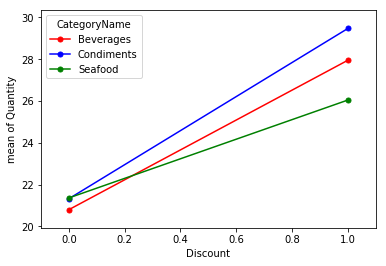

In [38]:
from statsmodels.graphics.factorplots import interaction_plot
q2_data_a = q2_data[(q2_data['CategoryName'] == 'Beverages') | (q2_data['CategoryName'] == 'Condiments') 
                    | (q2_data['CategoryName'] == 'Seafood')]
fig = interaction_plot(q2_data_a['Discount'],q2_data_a['CategoryName'],q2_data_a['Quantity'],
                       colors = ['red', 'blue', 'green'], ms=10)

The above plot shows how the mean 'Quantity' changes in relation to the 'Discount' for each of the three categories. Interestingly, the highest mean for each category occurs at a different 'Discount' level. For 'Beverages', 0.05; for 'Condiments', 0.15; and for 'Seafood', 0.25.

To dig a little deeper, we can run a multiple comparison of mean using Tukey HSD to see where there's a significant difference between two 'Discount' levels. To do this, we will also need to calculate the appropriate family-wise error rate. Since we have 6 'Discount' levels (0.0, 0.05, 0.10, 0.15, 0.20, and 0.25) and will choose 2 for each comparison, we will have a total of 15 combinations. 

In [39]:
m = [q2_data[q2_data['CategoryName'] == 'Beverages'], q2_data[q2_data['CategoryName'] == 'Condiments'],
    q2_data[q2_data['CategoryName'] == 'Seafood']]
results = []
for i in m:
    mc = multi.MultiComparison(i['Quantity'], i['Discount'])
    combinations = 15
    fwer = 1 - (1 - alpha)**combinations
    r = mc.tukeyhsd(fwer)
    results.append([i, r])
    print(r)

NameError: name 'multi' is not defined

From these results we can see that each category has several comparisons that have a statistically significant difference in mean of 'Quantity' of product sold in an order. 

For 'Beverages', going from no discount to either a 0.05, 0.10, or 0.20 discount all show a moderate increase in 'Quantity' with the highest increase being with a 'Discount' of 0.05. We also see that, strangely, a 'Discount' of 0.20 or 0.25 both have a lower average 'Quantity' when compared with a 'Discount' of 0.05.

For 'Condiments'

0.05   0.15  -9.9551   -18.14  -1.7703  True 
 0.05   0.2   -5.3077  -13.3595  2.7441 False 
 0.05   0.25  -10.6322 -19.0289 -2.2356  True 

In [ ]:
d05 = q2_data[q2_data['Discount'] == 0.05].copy()
d10 = q2_data[q2_data['Discount'] == 0.10].copy()
d15 = q2_data[q2_data['Discount'] == 0.15].copy()
d20 = q2_data[q2_data['Discount'] == 0.20].copy()
d25 = q2_data[q2_data['Discount'] == 0.25].copy()


mc = multi.MultiComparison(d05['Quantity'], d05['CategoryName'])
print(mc.tukeyhsd())

mc = multi.MultiComparison(d10['Quantity'], d10['CategoryName'])
print(mc.tukeyhsd())

mc = multi.MultiComparison(d15['Quantity'], d15['CategoryName'])
print(mc.tukeyhsd())

mc = multi.MultiComparison(d20['Quantity'], d20['CategoryName'])
print(mc.tukeyhsd())

mc = multi.MultiComparison(d25['Quantity'], d25['CategoryName'])
print(mc.tukeyhsd())



In [ ]:
cats = q2_data['CategoryName'].unique()
disc = q2_data['Discount'].unique()
for i in disc:
    for j in cats:
        c = 0
        while c < len(cats):
            print(str(i) + " " + str(j) + " " + str(cats[c]))
            X = q2_data['Quantity'][(q2_data['Discount'] == i) & (q2_data['CategoryName'] == j)]
            y = q2_data['Quantity'][(q2_data['Discount'] == i) & (q2_data['CategoryName'] == cats[c])]
            p = stats.ttest_ind(X, y)[1]
            print(p)
            c += 1

In [ ]:
results = []
for i in q2_data['CategoryName'].unique():
    i_data = q2_data[q2_data['CategoryName'] == i]
    formula = 'Quantity ~ ' + 
    lm = ols(formula, j_data).fit()
    table = sm.stats.anova_lm(lm, typ=1)
    results.append([str(i) + " + " + str(j), table['F'].iloc[0], table['PR(>F)'].iloc[0]])

Since we are doing some post-hoc testing, we need to use a Bonferroni correction to avoid p-hacking. The adjusted alpha is calculated below.

In [ ]:
n = len(q2_data['CategoryName'].unique())
alpha = 0.05
bon_alpha = alpha/n
bon_alpha

With our new adjusted alpha, we can now view the results where the p-value is less than our 'bon_alpha' value.

In [ ]:
for i in results:
    if i[2] < bon_alpha:
        print(i)

We can see that 3 of the categories produced results with significant probabilities. Out of these, 'Beverages' and 'Dairy Products' both have high F-values of ~13.74 and ~13.56 respectively, while 'Condiments' has a lesser F-value of ~9.1. From these results, it would suggest that for products in the categories of 'Beverages', 'Dairy Products', and 'Condiments', providing a discount will almost always increase the quantity of product sold. Furthermore, that increase in product sold will be highest in 'Beverages' and 'Dairy Products'.

### Our findings show that having a discount on a product most likely will increase the quantity of product order but the actual amount of discount is statistically insignificant. 

# <center> Conclusion

####  <center> In this project we investigated several questions revolving around discounts given to products as well as the different categories of products and the employees who performed each order. Through our investigations we learned the following about the company's sales:
    
    1) Providing a discount for an order increases the quantity of product ordered.
    2) The level of discount does not affect the quantity of product ordered.
    3) The use of a discount has the same effectiveness across all categories of product.
    4) We cannot recommend an optimal discount level given the unit price of a product.
    5) There is some variance in the performance of the employees but we cannot say that any one employee performs  better on average than another.
    6) No employees excel at selling a particular category of product compared to the other employees.
    7) Meat and poultry products by far provide the highest amount in savings for customers.
    

####  <center> Using these findings, the company can increase their revenue by providing a discount on more orders without worrying about the amount of discount to offer, the category of product, or the product's unit price. They can also see that their employees are all on the relatively same level in terms of performance but also realize that none of their employees are specialized in selling a particular type of product. In addition, they can see that their meat and poultry products offer their customers the most savings so they can perhaps advertise that fact to boost sales and brand awareness.
    